<img src='../frameworks/img/EU-Copernicus-EUM-WEKEO_banner_logo.png' align='right' width='75%'></img>

<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_4_OLCI_bands_RGB.ipynb"><< OLCI bands and RGB imagery</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_6_OLCI_CHL_comparison.ipynb">Comparing OLCI chlorophyll products >></a>

Copernicus Marine Training Service <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://trainhub.eumetsat.int/ocean/sensors/1_5_OLCI_plot_spectral_radiances_reflectances.ipynb"><img src="https://img.shields.io/badge/Launch-TrainHub-Blue.svg" alt="Open in TrainHub"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
    <div style="float:left"><a href="https://mybinder.org/v2/gl/eumetlab%2Focean%2Fsensors%2Flearn-olci/main?labpath=1_OLCI_introductory/1_5_OLCI_plot_spectral_radiances_reflectances.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
    <div style="float:left"><a href="https://colab.research.google.com/github/eumetlab/ocean/sensors/learn-olci/blob/main/1_OLCI_introductory/1_5_OLCI_plot_spectral_radiances_reflectances.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" /></a></div>
    <div style="float:left"><p>&emsp;</p></div>
    <div style="float:left"><a href="https://studiolab.sagemaker.aws/import/github/eumetlab/ocean/sensors/learn-olci/blob/main/1_OLCI_introductory/1_5_OLCI_plot_spectral_radiances_reflectances.ipynb"><img src="https://studiolab.sagemaker.aws/studiolab.svg" alt="Open In Studio Lab"/></a></div>
    <div style="float:left"><p>&emsp;</p></div>
    <div style="float:left"><a href="https://pccompute.westeurope.cloudapp.azure.com/compute/hub/user-redirect/git-pull?repo=https://github.com/eumetlab/ocean/sensors/learn-olci&urlpath=1_OLCI_introductory/1_5_OLCI_plot_spectral_radiances_reflectances.ipynb&branch=main"><img src="https://img.shields.io/badge/Open-Planetary%20Computer-black?style=flat&logo=microsoft" alt="Open in Planetary Computer"/></a></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OLCI: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook:
- **[1_1_OLCI_data_access.ipynb](1_1_OLCI_data_access.ipynb)** (this will download the required OLCI products for this notebook)

</div>
<hr>

# 1.5 OLCI radiance and reflectance spectra
    
</div>

### Data used

| Product Description  | Data Store collection ID|  WEkEO HDA ID | Product Navigator |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|
| Sentinel-3 OLCI level-1B Full resolution | EO:EUM:DAT:0409 | EO:EUM:DAT:SENTINEL-3:OL_1_EFR___ | [link](https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:OL_1_EFR___NTC?query=OLCI&filter=satellite__Sentinel-3&filter=instrument__OLCI&filter=processingLevel__Level%201%20Data&s=advanced) |
| Sentinel-3 OLCI level-2 full resolution  | EO:EUM:DAT:0407 | EO:EUM:DAT:SENTINEL-3:OL_2_WFR___ | [link](https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:OL_2_WFR___NTC?query=OLCI&filter=satellite__Sentinel-3&filter=instrument__OLCI&filter=processingLevel__Level%202%20Data&s=advanced) |

### Learning outcomes

At the end of this notebook you will know;
* Objective


### Outline

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Radiance and reflectance](#section1)
 1. [Reading band data from the xml manifest file](#section2)
 1. [Reading in the radiance and reflectances](#section3)
 1. [Plotting the radiance and reflectances](#section4)
 1. [Applying your knowledge](#section5)

<hr>

In [1]:
import cartopy.crs as ccrs
import eumartools
import glob
import inspect
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import numpy as np
import os
import warnings
import xarray as xr
import xml.etree.ElementTree as ET

warnings.filterwarnings('ignore')

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Radiance and reflectance
[Back to top](#TOC_TOP)

</div>

blurb

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Reading band data from the xml manifest file
[Back to top](#TOC_TOP)

</div>

In [2]:
SAFE_directories = [
    os.path.join(os.getcwd(), 'products', 
    'S3A_OL_1_EFR____20210717T101015_20210717T101315_20210718T145224_0179_074_122_1980_MAR_O_NT_002.SEN3'),
    os.path.join(os.getcwd(), 'products',
    'S3A_OL_2_WFR____20210717T101015_20210717T101315_20210718T221347_0179_074_122_1980_MAR_O_NT_003.SEN3')
    ]

In [3]:
# There is now a function for this print(inspect.getsource(eumartools.read_manifest))
wavelengths = []
wavelength_bands = []
wavelength_errors = []

for SAFE_directory in SAFE_directories:

    tree = ET.parse(os.path.join(SAFE_directory,'xfdumanifest.xml'))
    root = tree.getroot()
    match_dict = {"sentinel3":"http://www.esa.int/safe/sentinel/sentinel-3/1.0"}    
    wavelengths.append([float(item.text) for item in root.findall('.//sentinel3:centralWavelength', match_dict)])
    wavelength_errors.append([float(item.text) for item in root.findall('.//sentinel3:bandwidth', match_dict)])
    wavelength_bands.append([item.attrib["name"] for item in root.findall('.//sentinel3:band', match_dict)])

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Reading in the radiance and reflectance data
[Back to top](#TOC_TOP)

</div>

In [4]:
# makes box average. Will choose nearest point if latmin == latmax and lonmin == lonmax
lonmin = 0.0
lonmax = 1.0
latmin = 56.0
latmax = 57.0

# for minimap plotting only
grid_reduce = 5

In [5]:
geo_file = os.path.join(SAFE_directories[0],'geo_coordinates.nc')
geo_fid = xr.open_dataset(geo_file)
lon = geo_fid.longitude.data
lat = geo_fid.latitude
geo_fid.close()

In [6]:
# coords: print(inspect.getsource(eumartools.subset_image))
ij = eumartools.subset_image(lon, lat, [lonmin, lonmax, latmin, latmax])

In [7]:
# set up our variables
radiances_mean = []
radiances_upper = []
radiances_lower = []

reflectances_mean = []
reflectances_upper = []
reflectances_lower = []
reflectances_errs = []

In [8]:
RGB_dict = {}
# read everything we need from netcdf
for SAFE_directory in SAFE_directories:
    # open all the files at once
    band_vars = xr.open_mfdataset(glob.glob(os.path.join(SAFE_directory,'Oa*.nc')))
    for band_var in band_vars:
        print(f"Reading:  {band_var}")
        var = band_vars[band_var].data[ij[0]:ij[1],ij[2]:ij[3]]
        if "_err" in band_var:
            reflectances_errs.append(np.nanmean(var))
        elif "radiance" in band_var:
            radiances_mean.append(np.nanmean(var))
            radiances_upper.append(np.nanmean(var) + np.nanstd(var))
            radiances_lower.append(np.nanmean(var) - np.nanstd(var))
            if "Oa08" in band_var or "Oa06" in band_var or "Oa02" in band_var:
                # this is just to build our quick minimap
                RGB_dict[band_var] = band_vars[band_var].data[::grid_reduce, ::grid_reduce]
        elif "reflectance" in band_var:
            reflectances_mean.append(np.nanmean(var))
            reflectances_upper.append(np.nanmean(var) + np.nanstd(var))
            reflectances_lower.append(np.nanmean(var) - np.nanstd(var))
        else:
            print('Not processing this file')
    band_vars.close()

Reading:  Oa01_radiance
Reading:  Oa02_radiance
Reading:  Oa03_radiance
Reading:  Oa04_radiance
Reading:  Oa05_radiance
Reading:  Oa06_radiance
Reading:  Oa07_radiance
Reading:  Oa08_radiance
Reading:  Oa09_radiance
Reading:  Oa10_radiance
Reading:  Oa11_radiance
Reading:  Oa12_radiance
Reading:  Oa13_radiance
Reading:  Oa14_radiance
Reading:  Oa15_radiance
Reading:  Oa16_radiance
Reading:  Oa17_radiance
Reading:  Oa18_radiance
Reading:  Oa19_radiance
Reading:  Oa20_radiance
Reading:  Oa21_radiance
Reading:  Oa01_reflectance
Reading:  Oa01_reflectance_err
Reading:  Oa02_reflectance
Reading:  Oa02_reflectance_err
Reading:  Oa03_reflectance
Reading:  Oa03_reflectance_err
Reading:  Oa04_reflectance
Reading:  Oa04_reflectance_err
Reading:  Oa05_reflectance
Reading:  Oa05_reflectance_err
Reading:  Oa06_reflectance
Reading:  Oa06_reflectance_err
Reading:  Oa07_reflectance
Reading:  Oa07_reflectance_err
Reading:  Oa08_reflectance
Reading:  Oa08_reflectance_err
Reading:  Oa09_reflectance
Readi

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Plotting the radiance and reflectance spectra
[Back to top](#TOC_TOP)

</div>

In [9]:
# build minimap: see 1_4_OLCI_plot_spatial_RGB.ipynb for more details
rgb = np.dstack(((np.log10(RGB_dict["Oa08_radiance"] * 0.01) + 1.6516951369518393) / 1.9887713527138795,
                 (np.log10(RGB_dict["Oa06_radiance"] * 0.01) + 1.6516951369518393) / 1.9887713527138795,
                 (np.log10(RGB_dict["Oa02_radiance"] * 0.01) + 1.6516951369518393) / 1.9887713527138795))
                     
rgb = eumartools.normalise_image(rgb, unhitch='True')
rgb = eumartools.truncate_image(rgb)
rgb = eumartools.histogram_image(rgb, nbins=512)
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

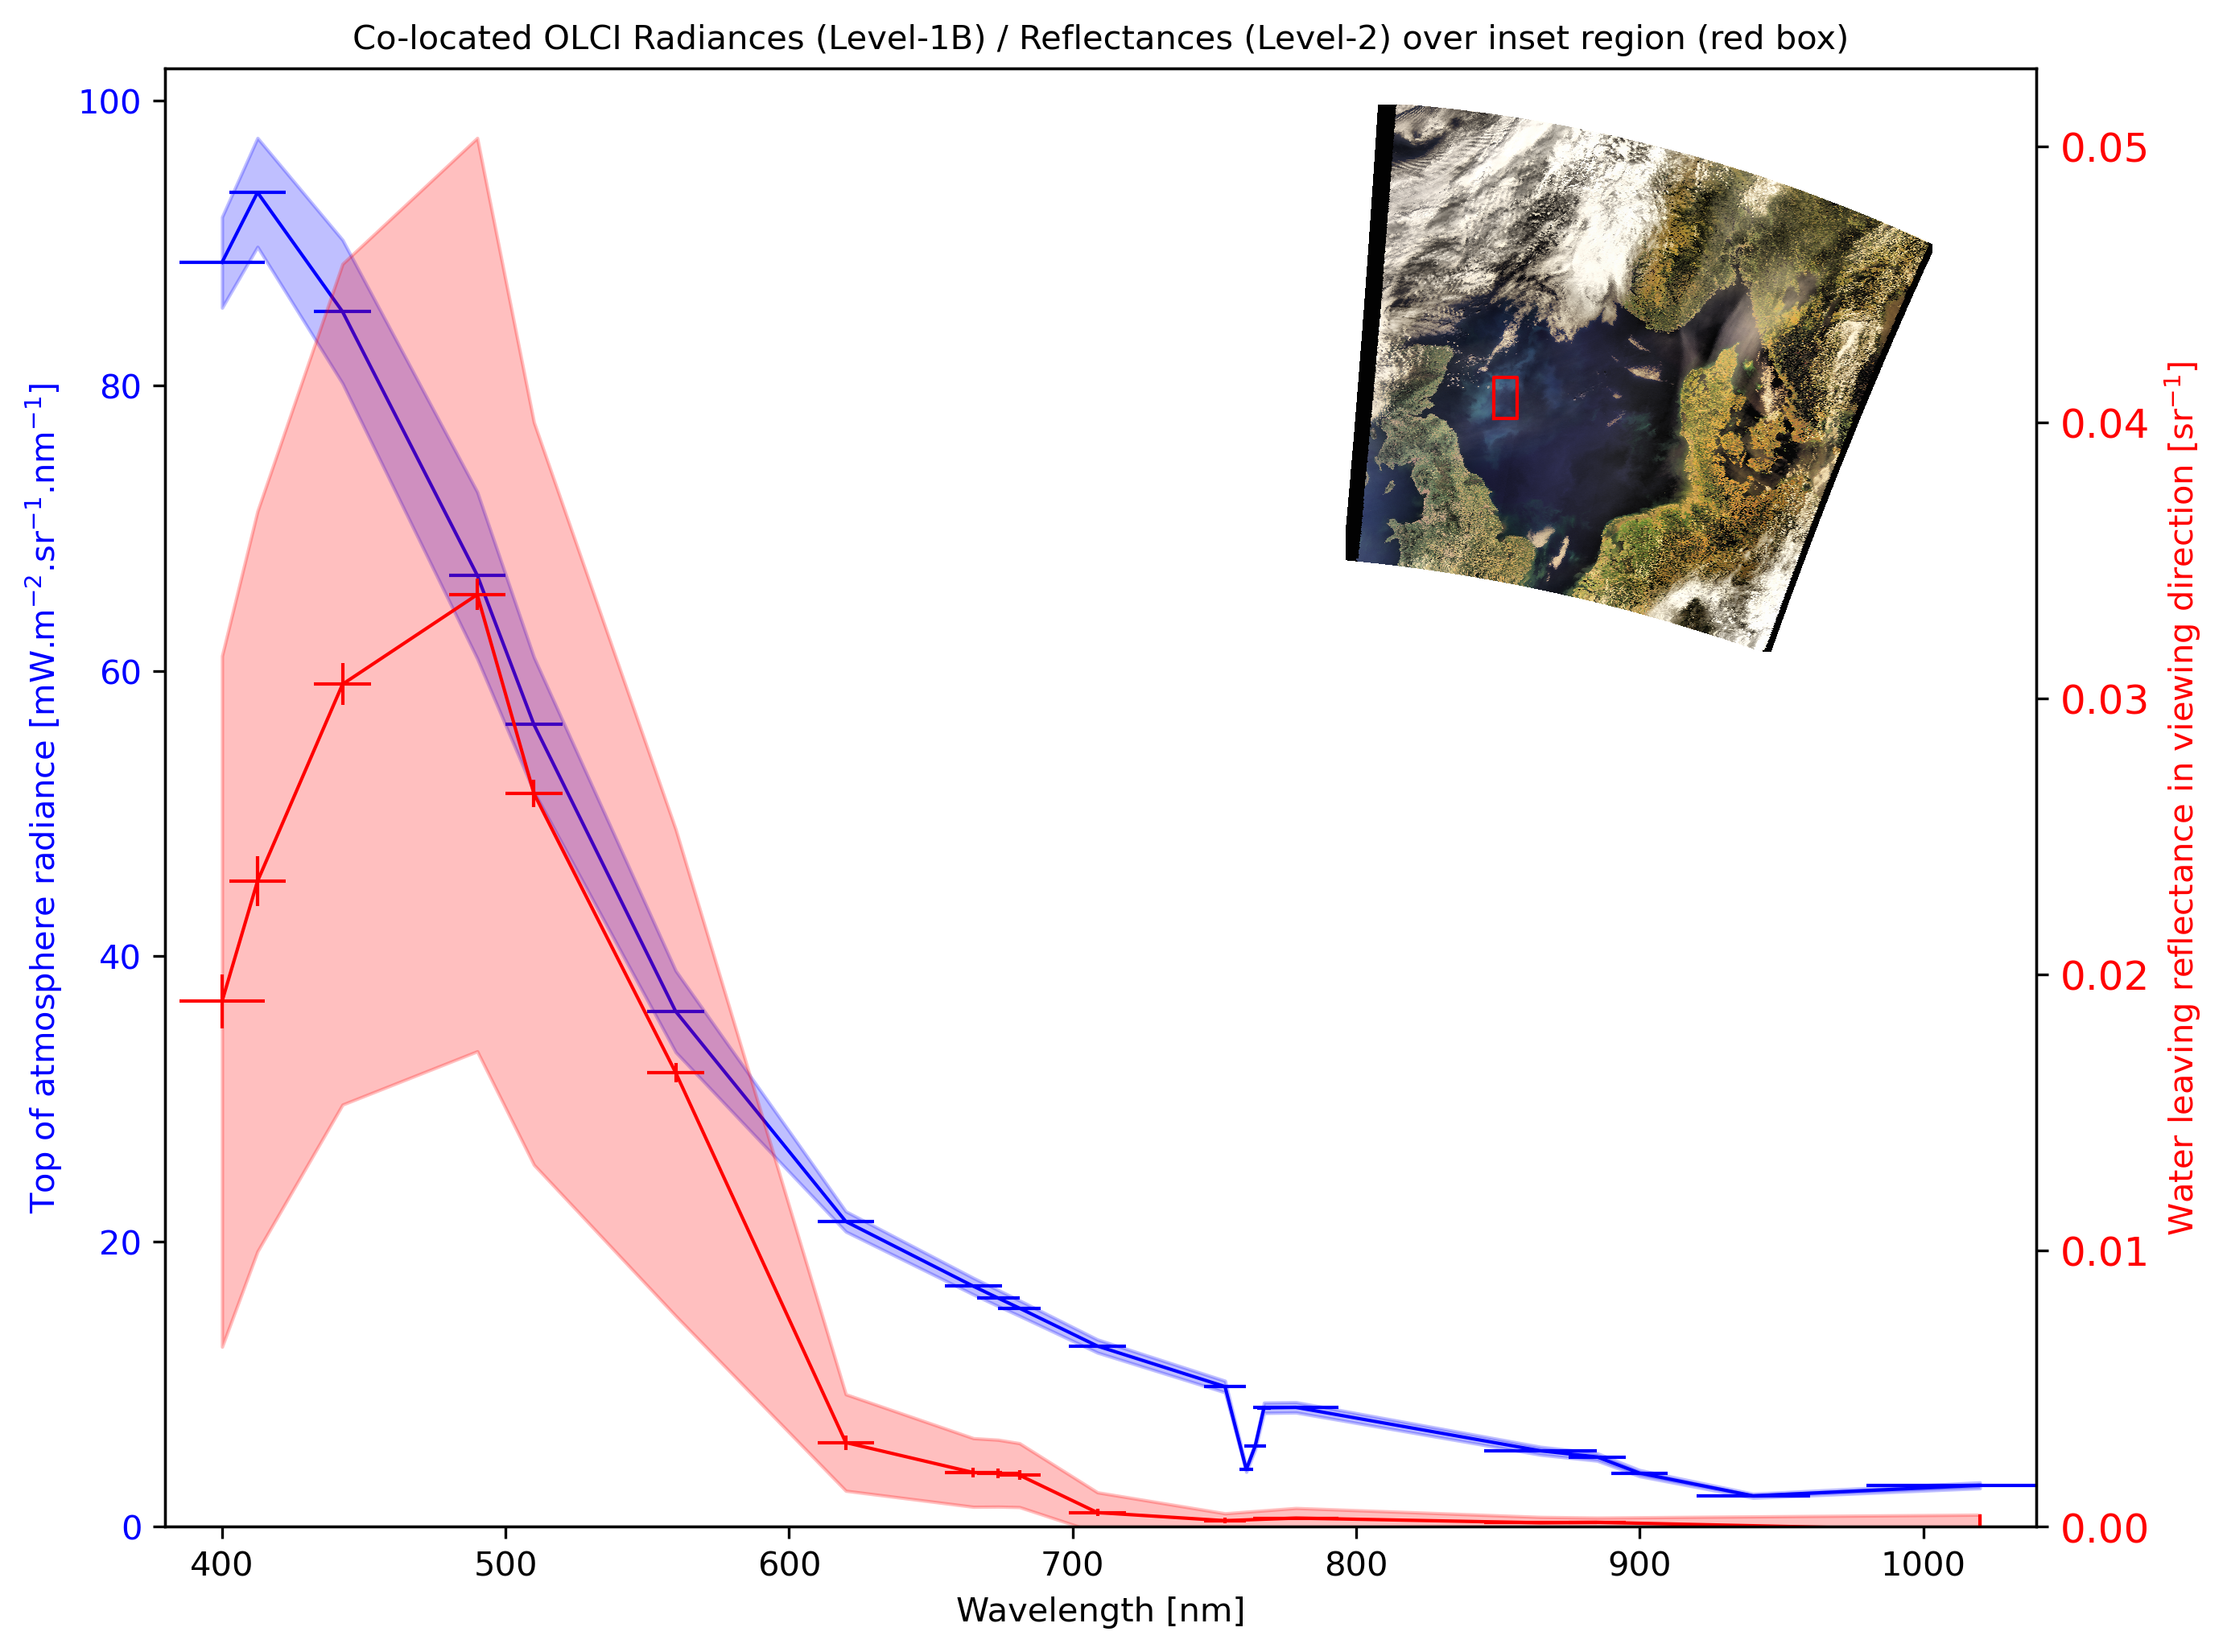

In [13]:
# plot the spectra
fig1 = plt.figure(figsize=(10, 8), dpi=300)

# radiances
plt.errorbar(wavelengths[0], radiances_mean, xerr=wavelength_errors[0], yerr=0, color='b', linewidth=1.0)
plt.fill_between(wavelengths[0], radiances_upper, radiances_lower, color='b', alpha=0.25)
plt.xlabel('Wavelength [nm]', fontsize=10)
plt.ylabel('Top of atmosphere radiance [mW.m$^{-2}$.sr$^{-1}$.nm$^{-1}$]', fontsize=10, color='b')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, color='b')
plt.xlim([wavelengths[0][0] - 20, wavelengths[0][-1] + 20])
plt.ylim([0, np.nanmax(radiances_upper)*1.05])

# reflectances
ax1 = plt.twinx()
plt.errorbar(wavelengths[1], reflectances_mean, xerr=wavelength_errors[1], yerr=reflectances_errs, 
             color='r', linewidth=1.0)
plt.fill_between(wavelengths[1], reflectances_upper, reflectances_lower, color='r', alpha=0.25)
plt.xlabel('Wavelength [nm]', fontsize=10)
plt.ylabel('Water leaving reflectance in viewing direction [sr$^{-1}$]', fontsize=10, color='r')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, color='r')
plt.title('Co-located OLCI Radiances (Level-1B) / Reflectances (Level-2) over inset region (red box)', fontsize=10);
plt.xlim([wavelengths[0][0] - 20, wavelengths[0][-1] + 20])
plt.ylim([0, np.nanmax(reflectances_upper)*1.05])

# minimap
m = plt.axes(projection=ccrs.Mercator())
m.pcolormesh(lon[::grid_reduce, ::grid_reduce], lat[::grid_reduce, ::grid_reduce],
             lon[::grid_reduce,::grid_reduce], color=colorTuple, edgecolors=None, transform=ccrs.PlateCarree())
ip = InsetPosition(ax1, [0.6, 0.6, 0.375, 0.375])
m.set_axes_locator(ip)
m.axis('off')
m.plot([lonmin, lonmax, lonmax, lonmin, lonmin],\
       [latmin, latmin, latmax, latmax, latmin],
       color='r', linewidth=1, transform=ccrs.PlateCarree())
plt.savefig('1_5_OLCI_spectra.png', bbox_inches='tight')
plt.show()

<div class="alert alert-danger" role="alert">

## <a id='section5'></a>5. Applying your knowledge
[Back to top](#TOC_TOP)

</div>

### What to try next?

* Can you make spectral plots for turbid waters?
* Can you make spectral plots for other plankton blooms?
* How do you think we can improve the quality of our radiance/reflectance spectra over water?

<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>